<a href="https://colab.research.google.com/github/ipavlopoulos/palit/blob/main/code/explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%%capture
!gdown 1kNgqJCFZS4Q-P2YSaeaYp9P2bTobyOCV # the PLL dataset
!gdown 1oCHi55WtUwaKEKHi_YyuEM_mzXaLFCVm # the [checkpoint.pt] model
#!gdown 1JFOu1T3VidgPYHqo7XidMSyq6lUOWhCW # the [fcnn_clf.pt] xsplit model
!git clone https://github.com/ipavlopoulos/palit.git

In [ ]:
from palit.code.classification import *
pll = pd.read_pickle("pll.csv")
dataset = pll.explode("img")
dataset = dataset[dataset.img.notna()]
print("Lines num:", dataset.shape[0])

w,h = 300,50
img_data = pd.DataFrame(dataset.img.apply(lambda x: x.shape).tolist(), index=dataset.index, columns=["H", "W"])
dataset = dataset[(img_data.W>w)&(img_data.H>h)]
dataset.insert(0, "lid", range(1, dataset.shape[0]+1))

# Change the following lines according to the mod13 split for the xsplit model
pll_train, pll_test = train_test_split(dataset, test_size=0.1, random_state=2023)
pll_train, pll_val = train_test_split(pll_train, test_size=pll_test.shape[0], random_state=2023)
print(pll_train.shape[0], pll_val.shape[0], pll_test.shape[0]) 

print(pll_train.shape[0], pll_val.shape[0], pll_test.shape[0])

Lines num: 4717
2218 278 278
2218 278 278


In [ ]:
net = CNNCLF(4) # 4 classes
# Load fcnn_clf.pt if you are looking for the xsplit model
net.load_state_dict(torch.load("checkpoint.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Acc: 0.727


<Figure size 640x480 with 0 Axes>

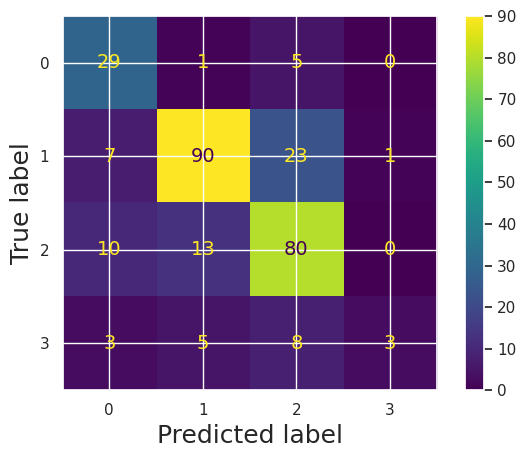

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

font = {'size'   : 14}
plt.rc('font', **font); plt.rcParams['axes.labelsize'] = 18; plt.rcParams['axes.titlesize'] = 18
plt.clf()

test_loader = DataLoader(ImageDataset(pll_test, transform=rs_transform), batch_size=1)
predictions, labels, loss, acc = validate_clf(net, test_loader)
print(f'Acc: {acc:.3f}')
ax = ConfusionMatrixDisplay.from_predictions(labels, predictions);
plt.tight_layout()
ax.figure_.savefig('confusion.pdf', format='PDF', dpi=300)

In [ ]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.59      0.83      0.69        35
           1       0.83      0.74      0.78       121
           2       0.69      0.78      0.73       103
           3       0.75      0.16      0.26        19

    accuracy                           0.73       278
   macro avg       0.71      0.63      0.62       278
weighted avg       0.74      0.73      0.72       278



# Saliency

In [ ]:
def saliency(model, inputs, labels, device='cpu'):
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs = inputs.requires_grad_(requires_grad=True)    
    outputs = model(inputs).to(device)
    loss = criterion(outputs, labels)
    loss.backward()  
    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)
    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')
    return fig, axs, outputs.detach()

!rm -R heatmaps 
!mkdir heatmaps

dataloader = DataLoader(ImageDataset(pll_test, transform=rs_transform), batch_size=1, shuffle=False)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
net.eval()
for batch_index, (batch, labels) in tqdm(enumerate(dataloader)):
  fig, axs, outputs = saliency(net, batch, labels)
  pred_date = np.argmax(outputs.cpu().detach(), 1).numpy()[0]+1
  row = pll_test.iloc[batch_index]
  plt.savefig(f"./heatmaps/lid_{row.lid:d}-uid_{row.uid:d}-gold_{row.date:d}-pred_{pred_date:d}")
  plt.close()

rm: cannot remove 'heatmaps': No such file or directory


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0it [00:00, ?it/s]

In [ ]:
%%capture
!zip heatmaps.zip heatmaps/*

# Ablation

rm: cannot remove 'ablations': No such file or directory


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0it [00:00, ?it/s]

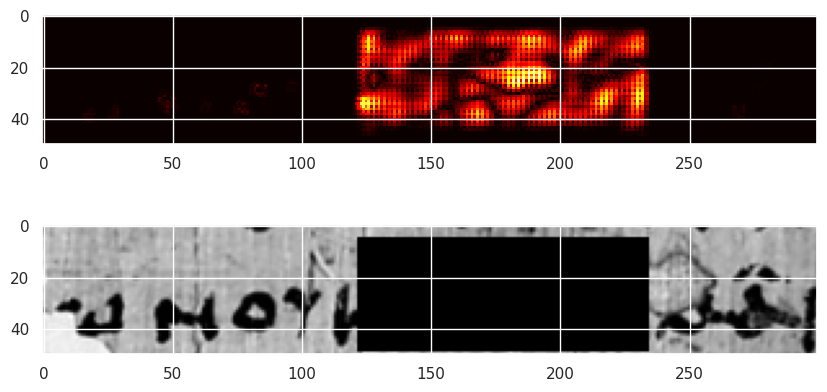

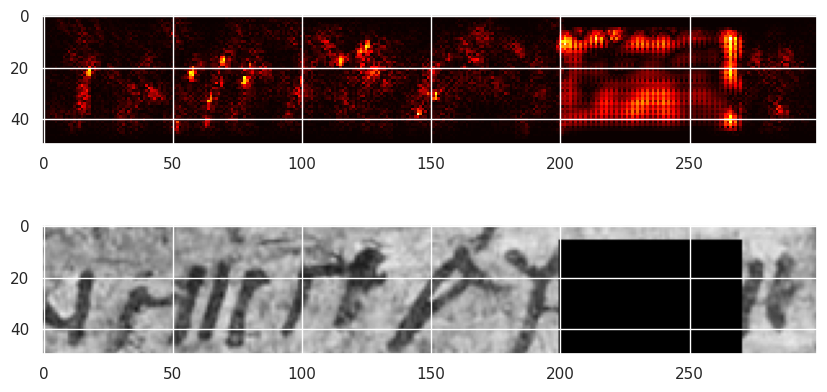

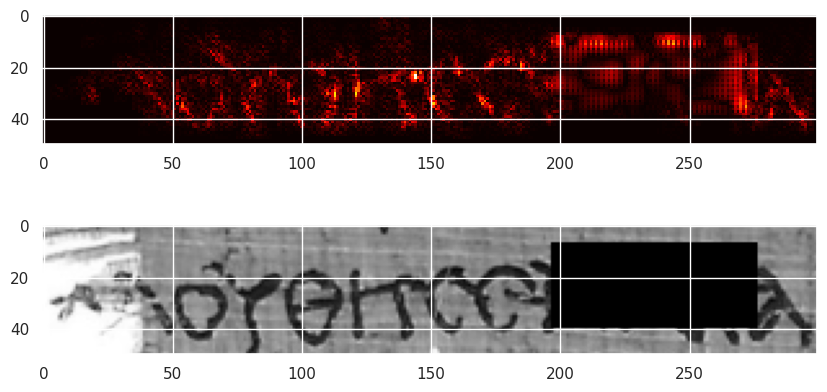

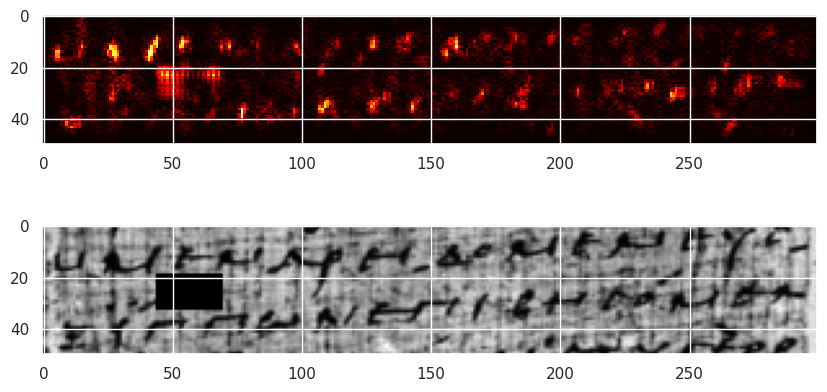

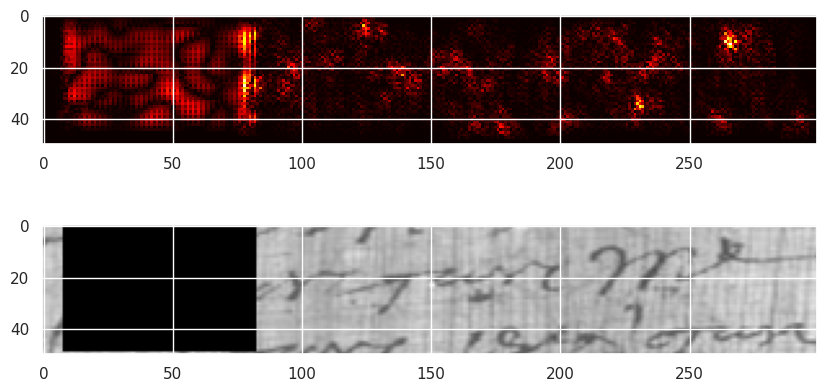

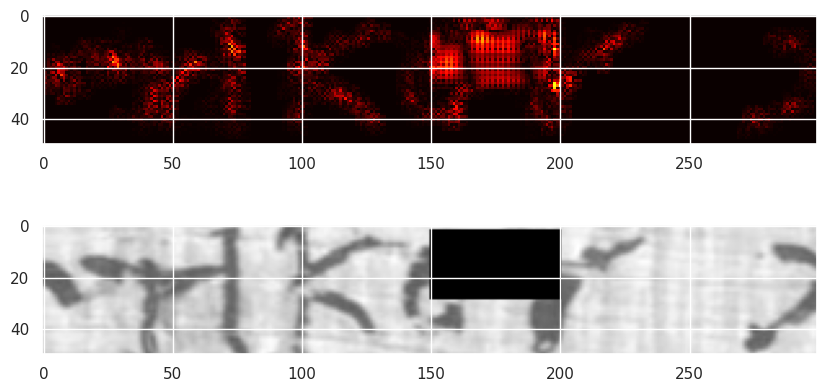

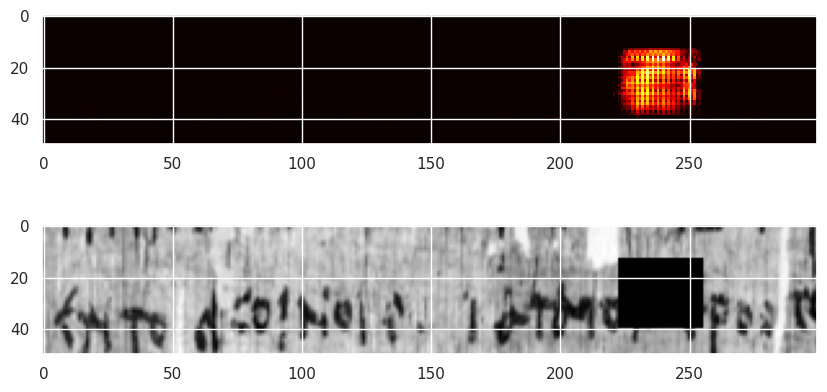

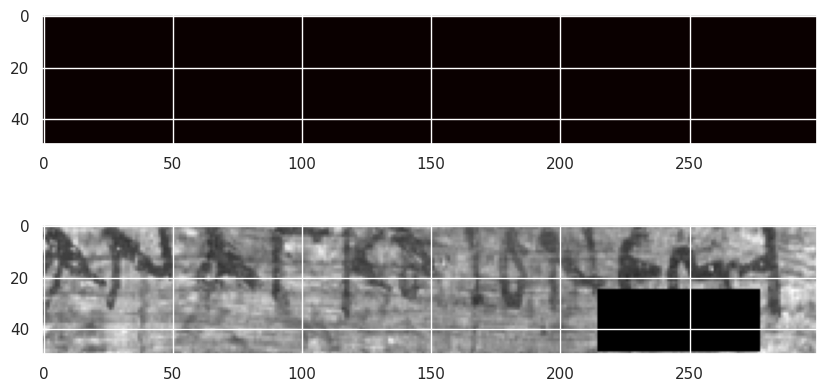

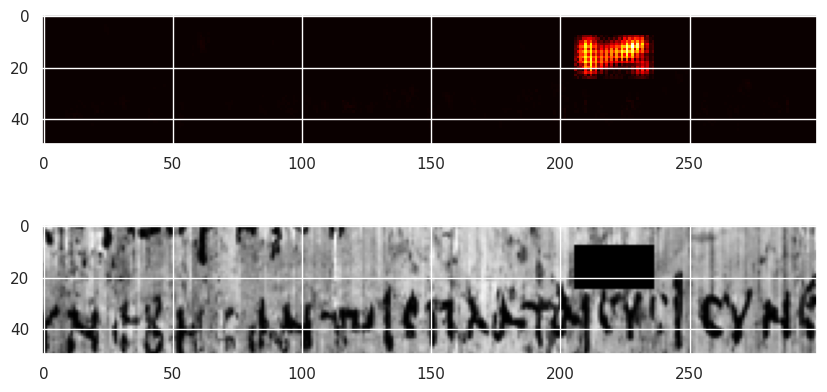

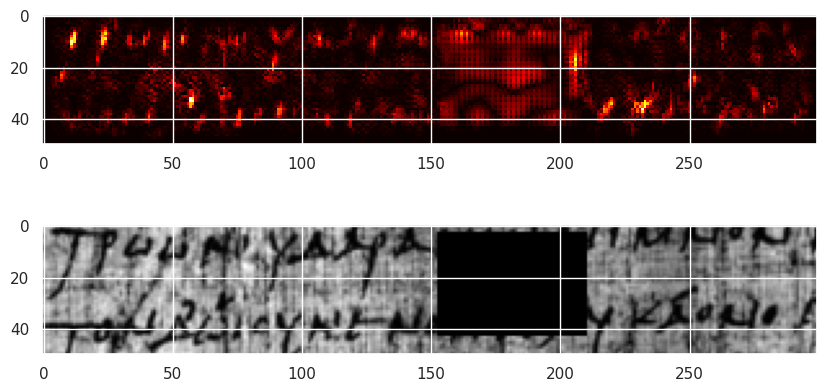

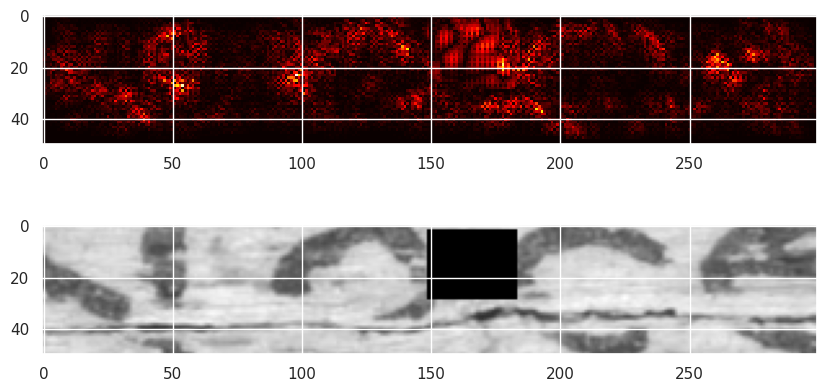

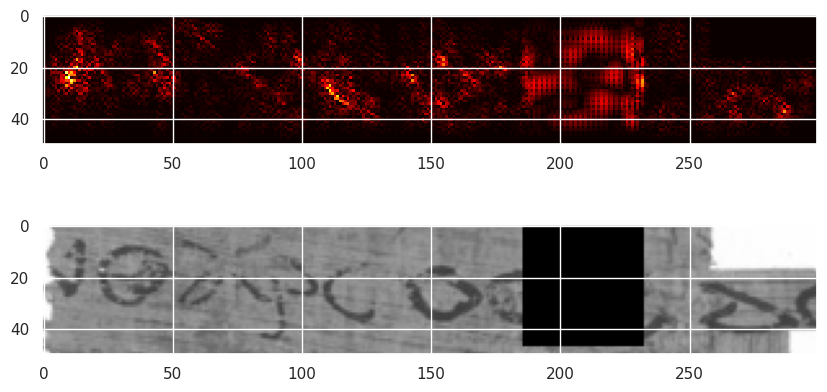

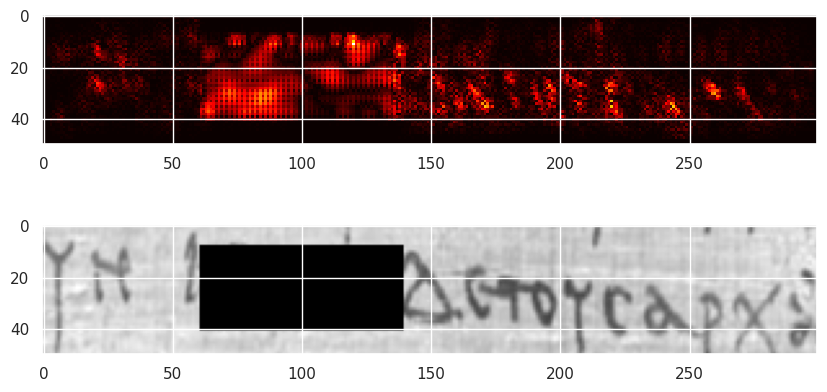

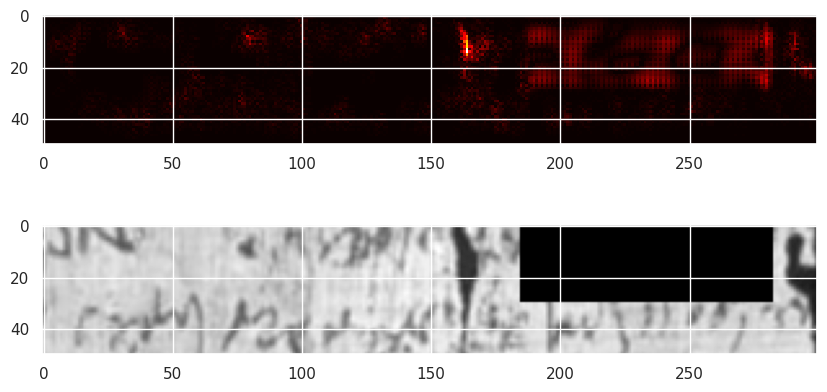

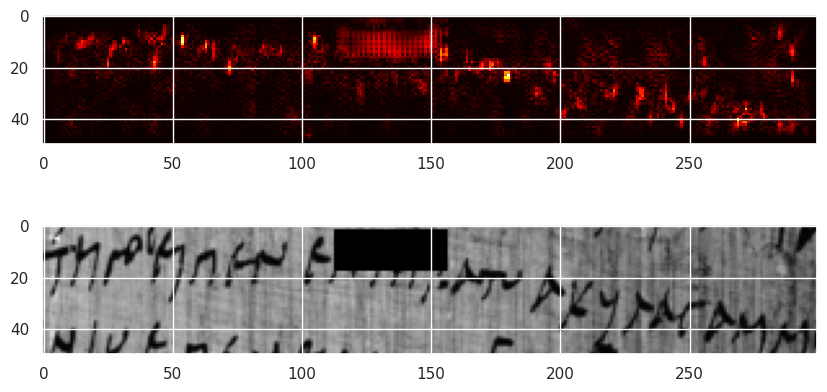

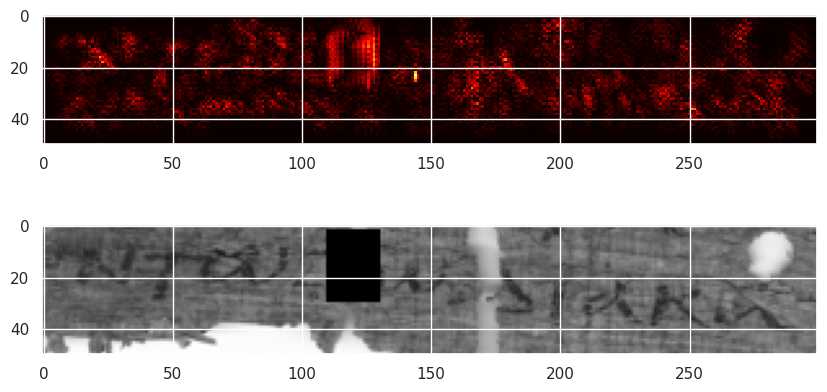

In [ ]:
!rm -R ablations
!mkdir ablations
batch_size = 16
dataloader = DataLoader(ImageDataset(pll_test.iloc[:batch_size], transform=white_fragment_ablation), batch_size=1)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
net.eval()
for batch_index, (batch, labels) in tqdm(enumerate(dataloader)):
    batch = batch.to(device)
    labels = labels.to(device)
    batch = batch.requires_grad_(requires_grad=True)
    
    output = net(batch).to(device)
    loss = criterion(output, labels)

    loss.backward()
  
    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')
    
    # saving the **black** box ablations
    row = pll_test.iloc[batch_index]
    plt.savefig(f"./ablations/bb-lid_{row.lid:d}-uid_{row.uid:d}-gold_{row.date:d}-pred_{pred_date:d}")

    plt.show()
    plt.close()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


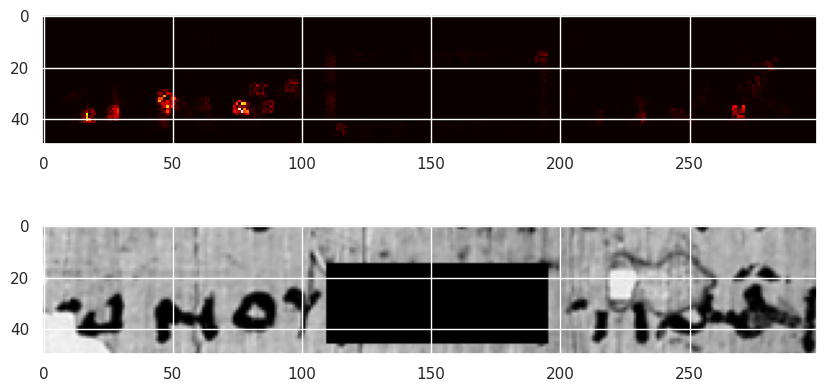

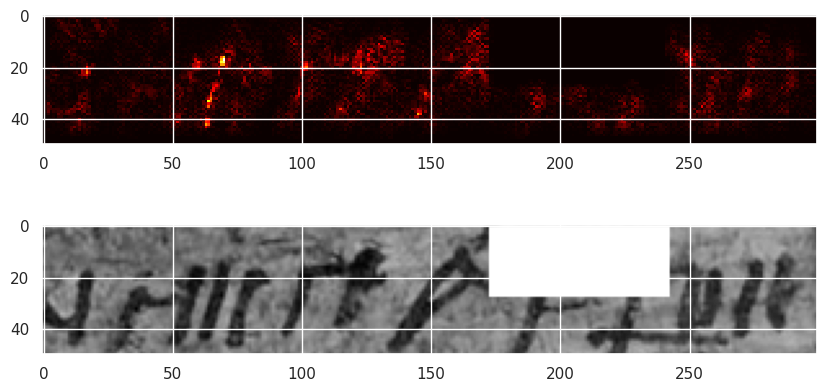

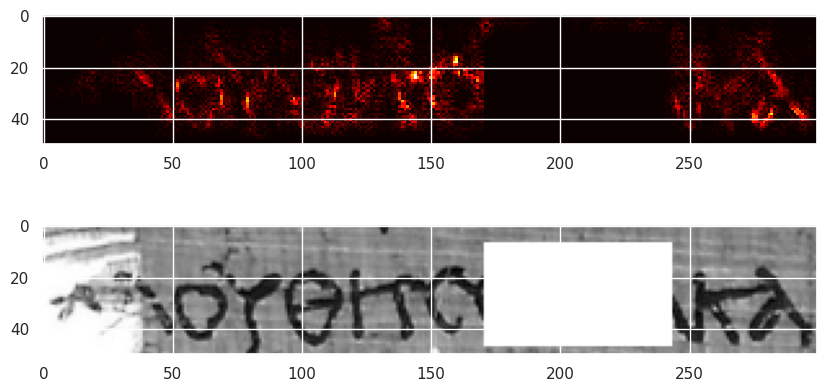

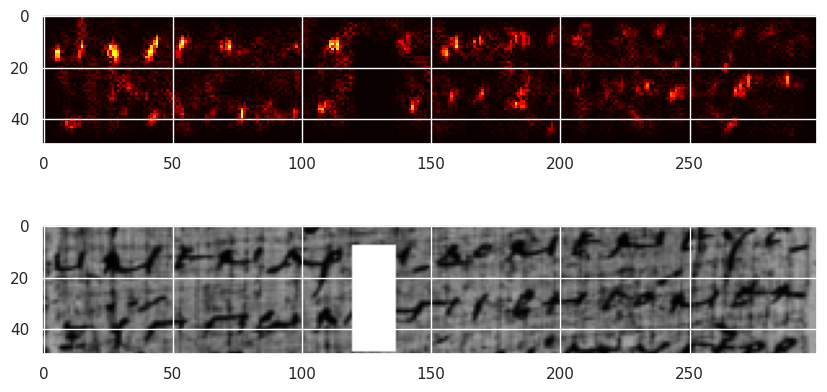

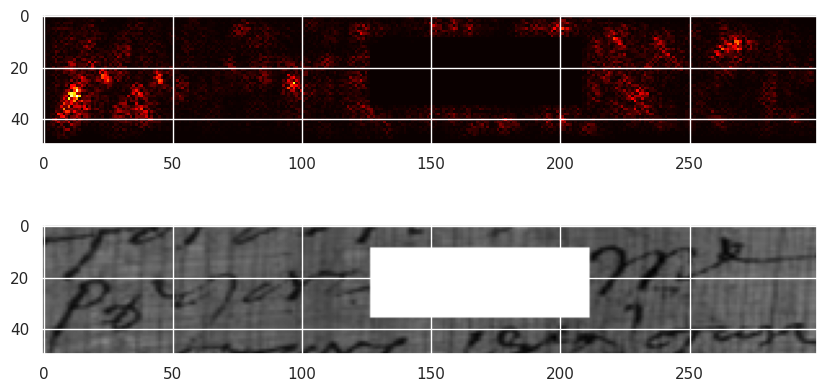

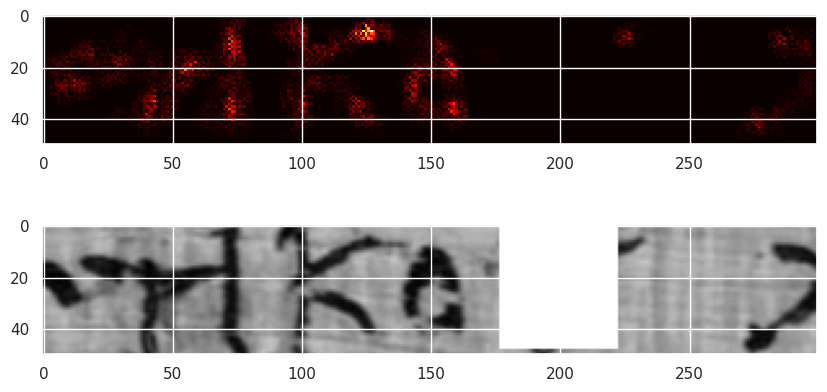

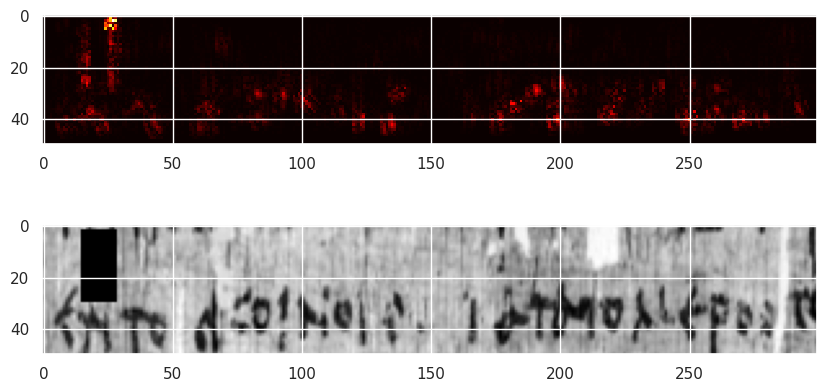

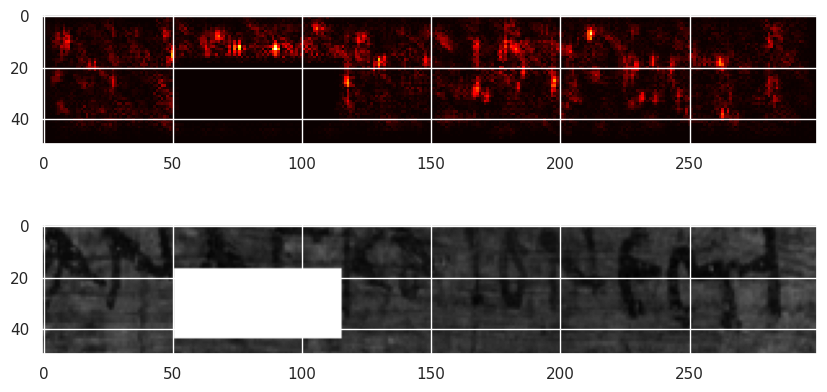

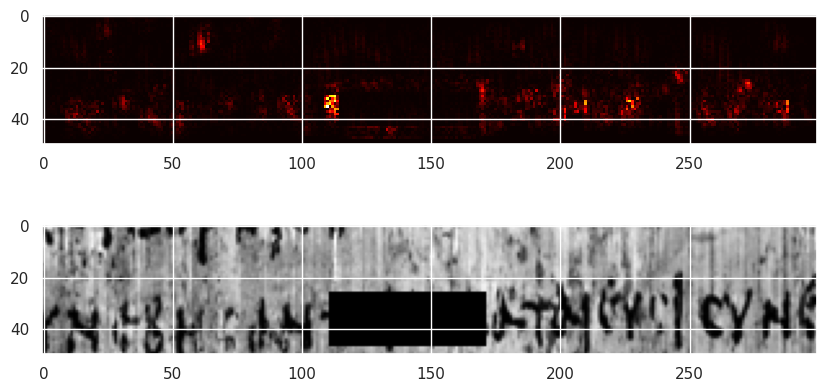

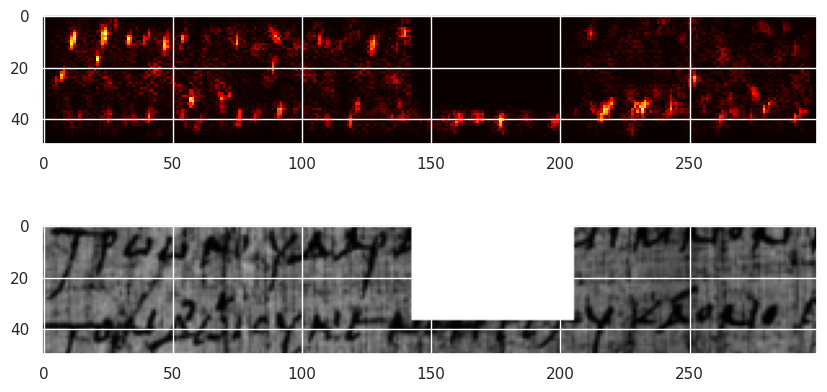

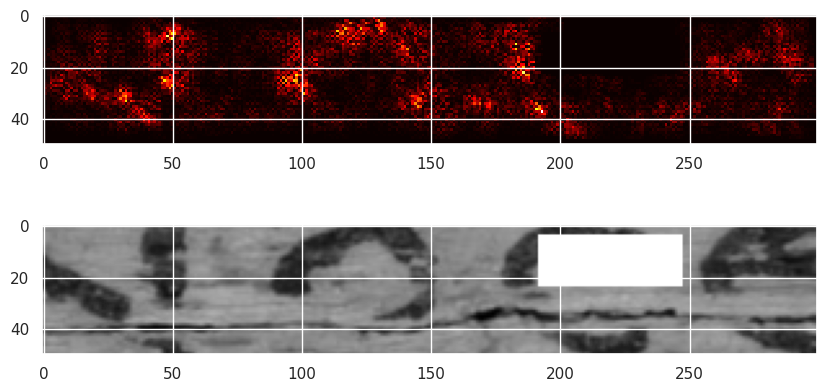

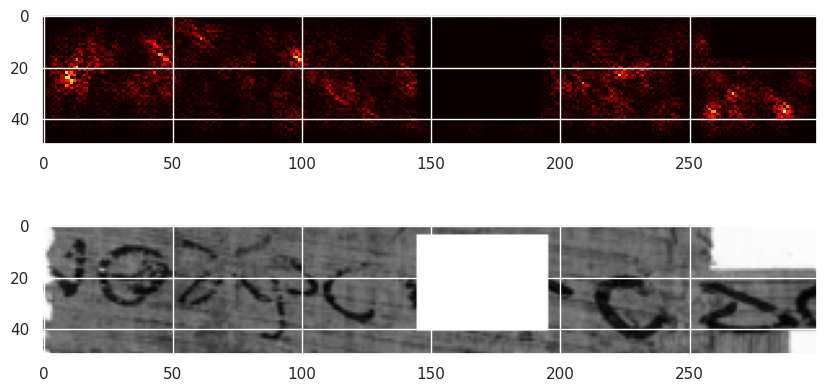

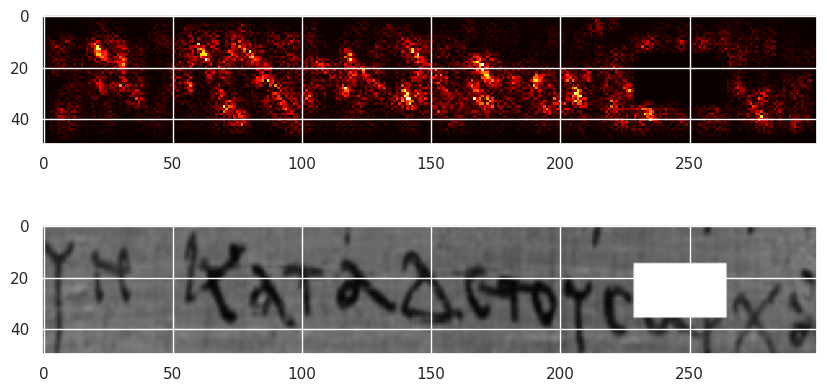

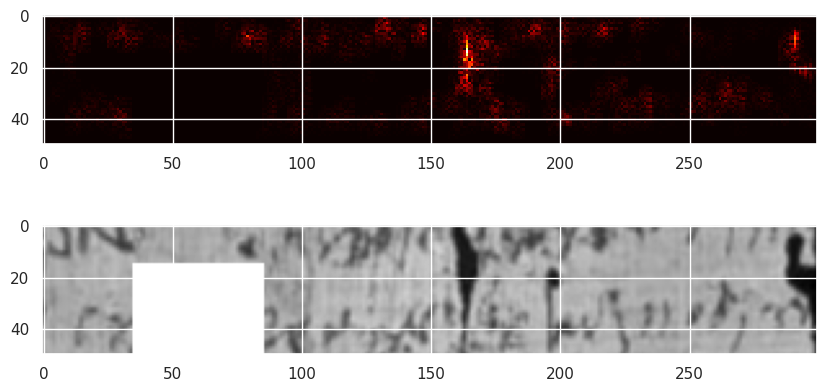

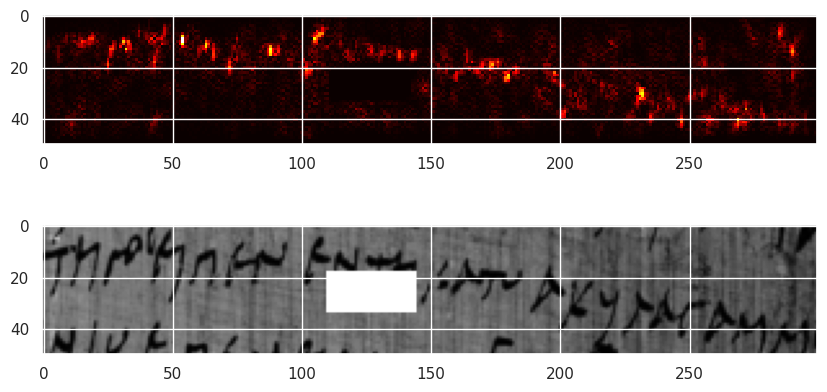

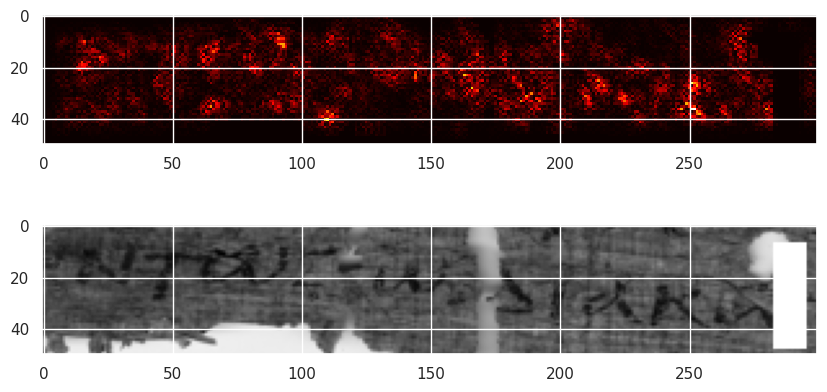

In [ ]:
batch_size = 16
dataloader = DataLoader(ImageDataset(pll_test.iloc[:batch_size], transform=black_fragment_ablation), batch_size=1)
device = 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
net.eval()
for batch_index, (batch, labels) in enumerate(dataloader):
    batch = batch.to(device)
    labels = labels.to(device)
    batch = batch.requires_grad_(requires_grad=True)
    
    output = net(batch).to(device)
    loss = criterion(output, labels)

    loss.backward()
  
    batch_grad = batch.grad.cpu().detach().numpy()
    batch_grad = np.squeeze(batch_grad)
    batch_grad = np.absolute(batch_grad)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    axs[0].imshow(batch_grad, cmap='hot', interpolation='nearest')
    axs[1].imshow(np.squeeze(batch.cpu().detach().numpy()), cmap='gray')

    # saving the **white** box ablations
    row = pll_test.iloc[batch_index]
    plt.savefig(f"./ablations/wb-lid_{row.lid:d}-uid_{row.uid:d}-gold_{row.date:d}-pred_{pred_date:d}")

    plt.show()
    plt.close()

In [ ]:
%%capture
!zip ablations.zip ablations/*

In [ ]:
pll_test[['lid', 'uid', 'date', 'quarter', 'filename_enc']].to_excel('test_data.xlsx')

# Dating undated papyri

In [ ]:
!gdown 1majEsBvm_pAyTtHqSGHpI3vnXLViiI5f  # the image lines in doubt
doubtful = pd.read_pickle("doubted.csv")
label_map = {'"-1/1"':0, "-1/1":0, "2,3":2.5, "3,4":3.5, "5,6":5.5, "6,7":6.5}
doubtful.date = doubtful.date.apply(lambda x: label_map[x] if x in label_map else x)

Downloading...
From: https://drive.google.com/uc?id=1majEsBvm_pAyTtHqSGHpI3vnXLViiI5f
To: /content/doubted.csv
100% 1.70G/1.70G [00:22<00:00, 76.5MB/s]


In [ ]:
d = doubtful[doubtful.date==2.5]
w,h = 300,50
img_data = pd.DataFrame(d.img.apply(lambda x: x.shape).tolist(), index=d.index, columns=["H", "W"])
d = d[(img_data.W>w)&(img_data.H>h)]

In [ ]:
def predict(model, dataloader, device="cpu"):
  predictions = []
  model.eval()
  with torch.no_grad():
      for id_batch, (inputs, labels) in enumerate(dataloader):
          inputs = inputs.to(device)
          outputs = model(inputs)
          predictions.append(outputs.cpu().numpy()[0])
  return predictions 

test_loader = DataLoader(ImageDataset(d, transform=rs_transform), batch_size=1)
predictions = predict(net, test_loader)
d.insert(6, "CE", predictions)
d.insert(0, "Papyrus", d.filename_enc.apply(lambda x: x.split("_")[1].replace(".jpg", "").replace(".png", "").replace("picture", "").replace("(1)", "")))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
d.CE.apply(np.argmax).apply(lambda x: x+1).value_counts()

3    70
2    47
1    16
4     1
Name: CE, dtype: int64

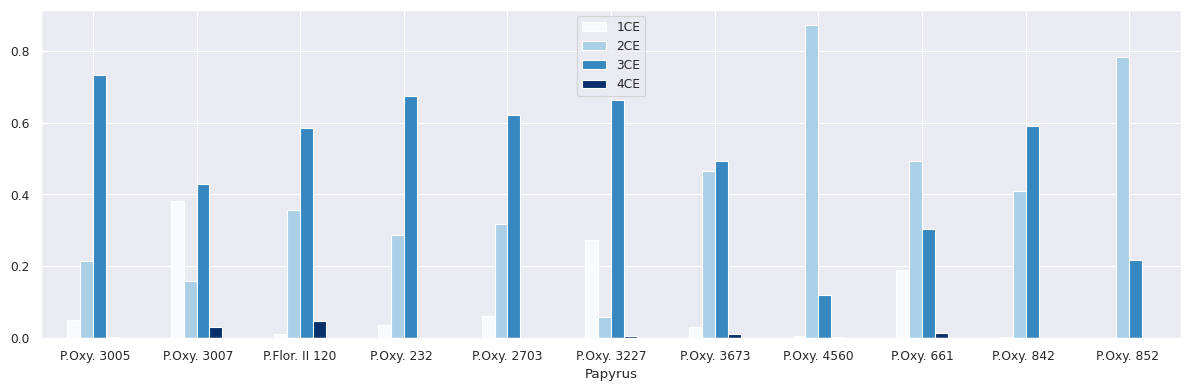

In [ ]:
# we could visualise the probability (one per line) per papyrus (11 in total)
import seaborn as sns; sns.set_theme('paper'); 
#sns.set(rc={'figure.figsize':(15,5)})
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)
papyri = list(d.Papyrus.unique())
estimations = pd.DataFrame(d.CE.apply(softmax).apply(pd.Series))
estimations['Papyrus'] = d.Papyrus
g = estimations.groupby('Papyrus')
gg = pd.DataFrame()
gg['1CE'] = g[0].apply(np.mean)
gg['2CE'] = g[1].apply(np.mean)
gg['3CE'] = g[2].apply(np.mean)
gg['4CE'] = g[3].apply(np.mean)
sns.set_style()
ax = gg.plot.bar(figsize=(12,4), colormap='Blues', rot=0);
plt.tight_layout()
ax.figure.savefig('undated.pdf', format='PDF', dpi=300)